In [ ]:
! git clone https://github.com/thsant/wgisd.git

Cloning into 'wgisd'...
remote: Enumerating objects: 4248, done.
remote: Counting objects: 100% (848/848), done.
remote: Compressing objects: 100% (839/839), done.
remote: Total 4248 (delta 19), reused 820 (delta 7), pack-reused 3400
Receiving objects: 100% (4248/4248), 1.39 GiB | 30.93 MiB/s, done.
Resolving deltas: 100% (342/342), done.
Checking out files: 100% (1849/1849), done.


In [ ]:
HEIGHT, WIDTH = 1365, 2048
MASKTHRESH = 0.5
from google.colab import drive
drive.mount('/googledrive')
MODELPATH = '/googledrive/MyDrive/uczelnia/computer_vision/instance_segmentation_grapes/models/'
from random import shuffle
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.ssd import det_utils
from torchvision.ops import nms
import torchvision
import logging
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import warnings
import random
import colorsys
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Polygon
from skimage.color import label2rgb
from google.colab.patches import cv2_imshow

def random_colors(n_colors, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / n_colors, 1, brightness) for i in range(n_colors)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def plot_item(img, boxes, mask, savename = None, maskthresh = MASKTHRESH):
    """
    Parameters:
        img : src image of shape (3, image_height, image_width) e.g. (3, 1365, 2048)
        boxes : boxes found objects (n_boxes, 4)
        mask : mask of found objects (n_boxes, image_height, image_width)
    Examples:
        sample parameters shape: ((3, 1365, 2048), (11, 4), (11, 1365, 2048))
    """
    if type(img) == torch.Tensor:
        img = img.detach().numpy()
    if type(boxes) == torch.Tensor:
        boxes = boxes.detach().numpy()
    if type(mask) == torch.Tensor:
        mask = mask.detach().numpy()
    if mask.shape[1] == 1:
        mask = mask.squeeze(1)
    if mask.dtype != np.uint8:
        mask = mask > maskthresh
        mask = mask.astype(np.uint8)
    fig, (ax0, ax1) = plt.subplots(figsize=(20,10), ncols=2, dpi = 200)

    # boxes = boxes[[12], ...]
    # mask = mask[[12], ...]

    # Number of instances
    n_boxes = boxes.shape[0]

    # Generate random colors
    colors = random_colors(n_boxes)

    for i, (x0, y0, x1, y1) in enumerate(boxes):
        color = np.array(colors[i])
        box_width = x1 - x0
        box_height = y1 - y0
        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax0.add_patch(p)
        ax0.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax1.add_patch(p)
        ax1.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)
        
        ax0.imshow(np.moveaxis(img, 0, -1))

    mask = np.moveaxis(mask, 0, -1)
    labels = np.zeros(mask.shape[0:2])
    for i in range(n_boxes):
        labels[mask[:,:,i] == 1] = i + 1
    mask_rgb = label2rgb(labels, colors=colors, bg_label=0)
    ax1.imshow(mask_rgb)
    if savename is not None:
        plt.savefig(savename)

class WGISDMaskedDataset(Dataset):
    def __init__(self, root, transforms=None, source='train'):
        self.root = root
        self.transforms = transforms
        
        if source not in ('train', 'test', 'valid'):
            print('source should be by "train" or "test"')
            return None

        srcpref = source
        if source == 'valid':
            srcpref = 'test'
        source_path = os.path.join(root, f'{srcpref}_masked.txt')
        with open(source_path, 'r') as fp:
          lines = fp.readlines()
          ids = [l.rstrip() for l in lines]# removes /n at the end of each line

        self.imgs = [os.path.join(root, 'data', f'{id}.jpg') for id in ids]
        self.masks = [os.path.join(root, 'data', f'{id}.npz') for id in ids]
        self.boxes = [os.path.join(root, 'data', f'{id}.txt') for id in ids]

        #performing additional dataset split test -> test, valid
        if source == 'valid':
            self.imgs = self.imgs[len(self.imgs) // 2 : ]
            self.masks = self.masks[len(self.masks) // 2 : ]
            self.boxes = self.boxes[len(self.boxes) // 2 : ]
        elif source == 'test':
            self.imgs = self.imgs[ : len(self.imgs) // 2 ]
            self.masks = self.masks[ : len(self.masks) // 2 ]
            self.boxes = self.boxes[ : len(self.boxes) // 2 ]

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        box_path = self.boxes[idx]

        img = Image.open(img_path).convert("RGB")
        
        if self.transforms is None:
            pass
        else:
            img = np.array(img)
            img = self.transforms(torch.as_tensor(img, dtype=torch.uint8))

        img = np.array(img)
        # Normalize
        img = (img - img.min()) / np.max([img.max() - img.min(), 1])
        img = np.moveaxis(img, -1, 0)
        img = torch.as_tensor(img, dtype=torch.float32)  


        wgisd_masks = np.load(mask_path)['arr_0'].astype(np.uint8)
        masks = np.moveaxis(wgisd_masks, -1, 0) 

        num_objs = masks.shape[0]
        all_text = np.loadtxt(box_path, delimiter = " ", dtype = np.float32)
        wgisd_boxes = all_text[:,1:]
        assert(wgisd_boxes.shape[0] == num_objs)

        labels = np.ones(num_objs, dtype=np.int64)

        # According to WGISD:
        #
        # These text files follows the "YOLO format"
        # 
        # CLASS CX CY W H
        # 
        # class is an integer defining the object class – the dataset presents 
        # only the grape class that is numbered 0, so every line starts with 
        # this "class zero" indicator. The center of the bounding box is the 
        # point (c_x, c_y), represented as float values because this format 
        # normalizes the coordinates by the image dimensions. To get the 
        # absolute position, use (2048 c_x, 1365 c_y). The bounding box 
        # dimensions are given by W and H, also normalized by the image size.
        #
        # Torchvision's Mask R-CNN expects absolute coordinates.
        _, height, width = img.shape

        boxes = []
        for box in wgisd_boxes:
            x1 = box[0] - box[2]/2
            x2 = box[0] + box[2]/2
            y1 = box[1] - box[3]/2
            y2 = box[1] + box[3]/2
            boxes.append([x1 * width, y1 * height, x2 * width, y2 * height])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id
        }

        return img, target

    def __len__(self):
        return len(self.imgs)

def get_maskrcnn(pretrained = True):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #replace head predictor (boxes)
    NUM_CLASSES=2
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    #replace mask predictor
    fg_iou_thresh = 0.6 #min IoU to be considered as positive
    bg_iou_thresh = 0.6 #max IoU to be considered as negative
    model.roi_heads.proposal_matcher.low_threshold = bg_iou_thresh
    model.roi_heads.proposal_matcher.high_threshold = fg_iou_thresh
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)
    return model

def filter_results(results : dict, confidence_thresh = 0.8):
    """
    filters results in situ
    """
    scores = results['scores']
    results['boxes'] = results['boxes'][scores > confidence_thresh]
    results['labels'] = results['labels'][scores >confidence_thresh]
    results['masks'] = results['masks'][scores>confidence_thresh]
    results['scores'] = results['scores'][scores > confidence_thresh]
    return results

def nmscombined(orig_predicted, iou_thresh = 0.3):
    '''
    performs non max suppression on the results
    '''
    keep = nms(orig_predicted['boxes'], orig_predicted['scores'], iou_thresh)
    final_pred = orig_predicted
    final_pred['boxes'] = final_pred['boxes'][keep]
    final_pred['masks'] = final_pred['masks'][keep]
    final_pred['scores'] = final_pred['scores'][keep]
    final_pred['labels'] = final_pred['labels'][keep]
    return final_pred

def average_precision(GTmasks, predmasks, maskthresh = MASKTHRESH):
    """
    Parameters
    ----------
    GTmasks : Ground Truth masks
    predmasks : Predicted Masks from the model
    
    Returns
    ------------
    Precision
    """
    predmasks = predmasks > maskthresh
    #for each predmask compute nearest neighbor and return precision
    loss = 0
    npreds =0
    for predmask in predmasks:
        andresult=torch.logical_and(GTmasks, predmask )
        imgid = torch.argmax(andresult.sum([-1, -2]))
        gtmask = GTmasks[imgid]
        N_TP = torch.logical_and(gtmask, predmask).sum()
        N_FP = predmask.sum() - N_TP
        loss += N_TP / (N_TP + N_FP)
        npreds +=1
    return loss / npreds

def average_recall(GTmasks, predmasks, maskthresh = MASKTHRESH):
    """
    Parameters
    ----------
    GTmasks : Ground Truth masks
    predmasks : Predicted Masks from the model
    
    Returns
    ------------
    Recall
    """
    predmasks = predmasks > maskthresh
    #for each predmask compute nearest neighbor and return recall
    loss = 0
    npreds =0
    for predmask in predmasks:
        andresult=torch.logical_and(GTmasks, predmask )
        imgid = torch.argmax(andresult.sum([-1, -2]))
        gtmask = GTmasks[imgid]
        N_TP = torch.logical_and(gtmask, predmask).sum()
        N_FN = gtmask.sum() - N_TP
        loss += N_TP / (N_TP + N_FN)
        npreds +=1
    return loss / npreds

def fscore_(precision, recall):
    return 2 * precision * recall / (precision + recall)

def fscore(GTmasks, predmasks, maskthresh = MASKTHRESH):
    predmasks = predmasks > maskthresh
    #for each predmask compute nearest neighbor and return precision
    precloss = 0
    recloss = 0
    npreds =0
    for predmask in predmasks:
        andresult=torch.logical_and(GTmasks, predmask )
        imgid = torch.argmax(andresult.sum([-1, -2]))
        gtmask = GTmasks[imgid]
        N_TP = torch.logical_and(gtmask, predmask).sum()
        N_FP = predmask.sum() - N_TP
        N_FN = gtmask.sum() - N_TP
        precloss += N_TP / (N_TP + N_FP)
        recloss += N_TP / (N_TP + N_FN)
        npreds +=1
    precision = precloss / npreds
    recall = recloss / npreds

    return fscore_(precision, recall)

def print_datsetslens():
    train=WGISDMaskedDataset('./wgisd/', source='train')
    test=WGISDMaskedDataset('./wgisd/', source='test')
    valid = WGISDMaskedDataset('./wgisd/', source='valid')
    print('trainlen:', len(train))
    print('testlen:', len(test))
    print('validlen:', len(valid))
    den = len(train) + len(valid) + len(test)
    print(f'split proportion: {len(train) / den} : {len(test) / den} : {len(valid) / den}')

Drive already mounted at /googledrive; to attempt to forcibly remount, call drive.mount("/googledrive", force_remount=True).


In [ ]:
MODELNAME='model3.pt'
LOGPREFIX = 'logof_'
savemodel = True
warnings.filterwarnings('ignore')
torch.manual_seed(0)
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005
MOMENTUM = 0.9
NUM_EPOCHS = 10
BATCH_SIZE = 2

logging.basicConfig(
    format='%(levelname)s: %(asctime)s %(message)s',
    level = logging.DEBUG,
    filename = os.path.join(MODELPATH,LOGPREFIX + MODELNAME.split('.')[0] + '.txt'),
    filemode='a'
)

dataset = WGISDMaskedDataset('./wgisd')
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True, num_workers = 2, collate_fn=lambda s: tuple(zip(*s)))

model = get_maskrcnn()

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
logging.info(f'DEVICE: {DEVICE}')
model.to(DEVICE)

for param in model.parameters():
    param.requires_grad = True
model.train()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
n_batches = len(dataloader)
totallosses_inepochs = []
masklosses_inepochs =[]

for epoch in range(1, NUM_EPOCHS + 1):
    logging.info(f'Current epoch: {epoch} of {NUM_EPOCHS}')
    lossacc= 0.0
    lossmaskacc = 0.0
    for batchid, (images, targets) in enumerate(dataloader, 1):
        images = [image.to(DEVICE) for image in images]
        targets = [ {k : v.to(DEVICE) for k, v in t.items()}for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # #logs
        lossmask=loss_dict['loss_mask'].item()
        lossmaskacc += lossmask
        lossacc += loss.item()
        if (batchid % 25 ==0):
            logging.info(f'lossmask:{lossmask}; loss:{loss.item()}; lossmaskacc:{lossmaskacc}; lossacc: {lossacc};')
    #TODO add validation loss calculation
    logging.info(f'finalepoch{epoch}: lossmask:{lossmask}; loss:{loss.item()}; lossmaskacc:{lossmaskacc}; lossacc: {lossacc};')
    print(f'finalepoch{epoch}: lossmask:{lossmask}; loss:{loss.item()}; lossmaskacc:{lossmaskacc}; lossacc: {lossacc};')
    totallosses_inepochs.append(lossacc)
    masklosses_inepochs.append(lossmaskacc)
if savemodel == True:
    torch.save(model.state_dict(), os.path.join(MODELPATH, MODELNAME))
logging.info(f'totallosses_inepochs: {totallosses_inepochs}')
logging.info(f'masklosses_inepochs: {masklosses_inepochs}')
logging.info('finished')

finalepoch1: lossmask:0.2906045615673065; loss:0.9145166277885437; lossmaskacc:22.47536252439022; lossacc: 71.47234070301056;
finalepoch2: lossmask:0.22981758415699005; loss:0.945505678653717; lossmaskacc:14.322275921702385; lossacc: 48.234725534915924;
finalepoch3: lossmask:0.27388039231300354; loss:0.7837556004524231; lossmaskacc:13.270611241459846; lossacc: 42.8925878405571;
finalepoch4: lossmask:0.23466838896274567; loss:0.6725770235061646; lossmaskacc:12.639134913682938; lossacc: 38.76751062273979;
finalepoch5: lossmask:0.23341745138168335; loss:0.7471639513969421; lossmaskacc:12.080042526125908; lossacc: 34.735831797122955;
finalepoch6: lossmask:0.2321588546037674; loss:0.9405063986778259; lossmaskacc:11.809507131576538; lossacc: 32.27685680985451;
finalepoch7: lossmask:0.17528963088989258; loss:0.4604153335094452; lossmaskacc:11.474566832184792; lossacc: 30.044736325740814;
finalepoch8: lossmask:0.2607760727405548; loss:0.7247419357299805; lossmaskacc:11.163489237427711; lossacc

Below we perform visualization of results:



In [ ]:
LOADMODELNAME='model3.pt'
model = get_maskrcnn()
if torch.cuda.is_available():
    model.load_state_dict(torch.load(os.path.join(MODELPATH, LOADMODELNAME)))
else:
    model.load_state_dict(torch.load(os.path.join(MODELPATH, LOADMODELNAME), map_location=torch.device('cpu')))

dataset=WGISDMaskedDataset('./wgisd/', source='train')
model.eval()

im, targets = dataset[0]
# cv2_imshow(np.moveaxis((im * 255).detach().numpy(), 0, -1))
res = model([im])
res = res[0] # only one image
boxes = res['boxes']
masks = res['masks']
srcboxes = targets['boxes']
srcmasks = targets['masks']
print("src:", srcboxes.shape[0], 'pred:', boxes.shape[0])

src: 13 pred: 19


In [ ]:
plot_item(im, boxes, masks, './train1pred')
plot_item(im, srcboxes, srcmasks, './train1src')

In [ ]:
filter_results(res)
boxes = res['boxes']
masks = res['masks']
print("src:", srcboxes.shape[0], 'pred:', boxes.shape[0])
plot_item(im, boxes, masks, './train1predfilter')
plot_item(im, srcboxes, srcmasks, './train1srcfilter')

Predictions on test dataset

In [ ]:
LOADMODELNAME='model3.pt'
model = get_maskrcnn()
if torch.cuda.is_available():
    model.load_state_dict(torch.load(os.path.join(MODELPATH, LOADMODELNAME)))
else:
    model.load_state_dict(torch.load(os.path.join(MODELPATH, LOADMODELNAME), map_location=torch.device('cpu')))

dataset=WGISDMaskedDataset('./wgisd/', source='test')
model.eval()

im, targets = dataset[0]
res = model([im])
res = res[0] # only one image
filter_results(res)
boxes = res['boxes']
masks = res['masks']
srcboxes = targets['boxes']
srcmasks = targets['masks']
print("src:", srcboxes.shape[0], 'pred:', boxes.shape[0])
plot_item(im, boxes, masks, './test1predfilter')
plot_item(im, srcboxes, srcmasks, './test1srcfilter')

Load model and view the metrics

totallosses_inepochs:


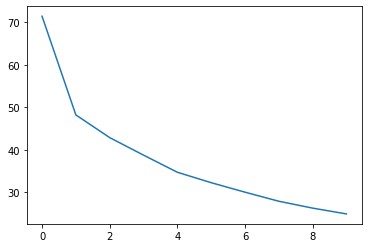

In [ ]:
print('totallosses_inepochs:')
plt.plot(totallosses_inepochs)

masklosses_inepochs:


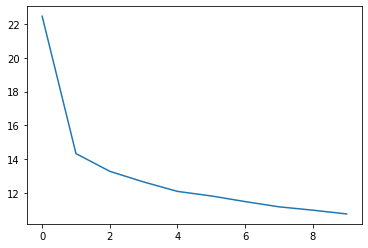

In [ ]:
print('masklosses_inepochs:')
plt.plot(masklosses_inepochs)

In [ ]:
res['scores']

tensor([0.9993, 0.9993, 0.9992, 0.9986, 0.9983, 0.9983, 0.9976, 0.9969, 0.9960,
        0.9959, 0.9948, 0.9938, 0.9833, 0.9708, 0.9645, 0.9557, 0.9089, 0.8975,
        0.6357, 0.5859], grad_fn=<IndexBackward0>)

In [ ]:
LOADMODELNAME='model3.pt'
model = get_maskrcnn()
if torch.cuda.is_available():
    model.load_state_dict(torch.load(os.path.join(MODELPATH, LOADMODELNAME)))
else:
    model.load_state_dict(torch.load(os.path.join(MODELPATH, LOADMODELNAME), map_location=torch.device('cpu')))

dataset=WGISDMaskedDataset('./wgisd/', source='test')
model.eval()

im, targets = dataset[0]
res = model([im])
res = res[0] # only one image
filter_results(res)
pass

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
avgprec= average_precision(targets['masks'], res['masks'])
avgrec = average_recall(targets['masks'], res['masks'])
fres = fscore(targets['masks'], res['masks'])
print("Precision:",avgprec)
print("Recall:", avgrec)
print("F1-score:", fres)

Precision: tensor(0.8965)
Recall: tensor(0.8179)
F1-score: tensor(0.8554)


In [ ]:
%time fscore(targets['masks'], res['masks'])

CPU times: user 4.74 s, sys: 82.2 ms, total: 4.82 s
Wall time: 5.01 s


tensor(0.8554)

Perform evaluation on test dataset and validation dataset:

In [ ]:
print_datsetslens()

trainlen: 110
testlen: 14
validlen: 14
split proportion: 0.7971014492753623 : 0.10144927536231885 : 0.10144927536231885


Metrics that we choice are precisision and recall, which are evaluated in terms of number of pixels

In [ ]:
!cat /googledrive/MyDrive/uczelnia/computer_vision/instance_segmentation_grapes/models/logof_model3.txt

cat: /googledrive/MyDrive/uczelnia/computer_vision/instance_segmentation_grapes/models/logof_model3.txt: No such file or directory
